In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from IPython.display import Markdown
from scipy.stats import f_oneway, kruskal

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
exp = "22"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = "~/data/hatespeech/unfiltered_ratings.feather"
rater_quality_path = "~/data/hatespeech/rater_quality_check.csv"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')

In [4]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})
# Remove all rows in which some item is missing
data = utils.filter_missing_items(data)
# Remove all rows in which the rater is not up to sufficient quality
rater_quality = pd.read_csv(rater_quality_path)
data = utils.filter_annotator_quality(data, rater_quality)
# Recode item responses
data = utils.recode_responses(
    data,
    insult={1: 0, 2: 1, 3: 2, 4: 3},
    humiliate={1: 0, 2: 0, 3: 1, 4: 2},
    status={1: 0, 2: 0, 3: 1, 4: 1},
    dehumanize={1: 0, 2: 0, 3: 1, 4: 1},
    violence={1: 0, 2: 0, 3: 1, 4: 1},
    genocide={1: 0, 2: 0, 3: 1, 4: 1},
    attack_defend={1: 0, 2: 1, 3: 2, 4: 3},
    hatespeech={1: 0, 2: 1})
# Only get comments targeting black / white people
data = data[data['target_race_white'] | data['target_race_black']]
data = data[data[keys.target_race_cols].sum(axis=1) == 1]
data['target_race'] = np.where(data['target_race_white'], 1, 2)

In [5]:
out_path = os.path.join(results_path, f"exp{exp}_out.txt")

In [6]:
with open(out_path) as f:
    lines = f.readlines()

In [7]:
bias_lines = lines[17588:30364]

In [8]:
bias_cut = bias_lines[4:-7]

In [30]:
n_samples = len(bias_cut)
observed = np.zeros(n_samples)
expected = np.zeros(n_samples)
bias_size = np.zeros(n_samples)
t_stats = np.zeros(n_samples)
p_vals = np.zeros(n_samples)
labeler_id = np.zeros(n_samples)
measure = np.zeros(n_samples)
race = np.zeros(n_samples)

for idx, line in enumerate(bias_cut):
    processed = line.replace('|', ' ').replace('>', ' ').replace('<', ' ').split()
    observed[idx] = float(processed[0])
    expected[idx] = float(processed[1])
    bias_size[idx] = float(processed[4])
    t_stats[idx] = float(processed[6])
    p_vals[idx] = float(processed[8])
    labeler_id[idx] = int(processed[13])
    measure = float(processed[14])
    if processed[16] == 'white':
        race[idx] = 0
    elif processed[16] == 'black':
        race[idx] = 1

In [31]:
df = pd.DataFrame({
    'observed': observed,
    'expected': expected,
    'bias': bias_size,
    't_statistics': t_stats,
    'p_values': p_vals,
    'labeler_id': labeler_id,
    'measure': measure,
    'race': race}).astype({'labeler_id': int})

In [32]:
df['annotator_race'] = 0
subview = data[data['labeler_id'].isin(df['labeler_id'])].drop_duplicates('labeler_id')
df.loc[df['labeler_id'].isin(subview[subview['annotator_race_black']]['labeler_id']), 'annotator_race'] = 1

In [33]:
df['bias_corrected'] = -df['bias']
df['bias_abs'] = df['bias'].abs()
df['annotator_race_name'] = np.where(df['annotator_race'] == 1, 'black', 'white')
df['target_race_name'] = np.where(df['race'] == 1, 'black', 'white')

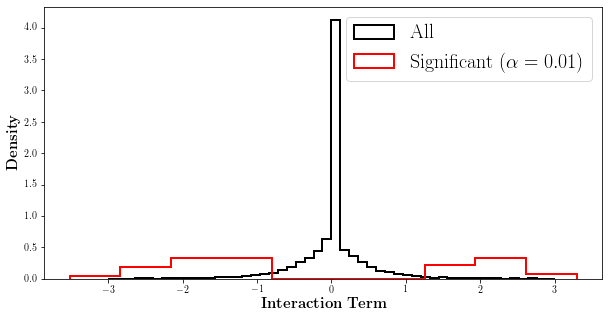

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(df['bias_corrected'], bins=np.linspace(-3, 3, 51), histtype='step', color='black', lw=2, density=True, label='All')
ax.hist(df[df['p_values'] < 0.01]['bias'], color='red', histtype='step', density=True, lw=2, label=r'Significant ($\alpha=0.01$)')
ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=15)
ax.set_ylabel(r'\textbf{Density}', fontsize=15)
ax.legend(prop={'size': 20})
#plt.savefig('interaction_terms.png', dpi=300)

In [29]:
df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias']

Series([], Name: bias, dtype: float64)

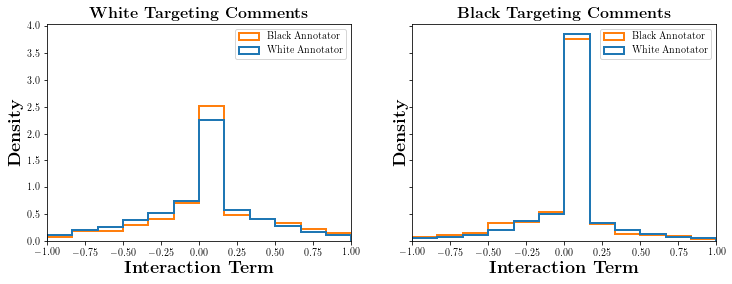

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 0)]['bias_corrected']],
    histtype='step',
    density=True,
    lw=2,
    bins=np.linspace(-1, 1, 13),
    label=['White Annotator', 'Black Annotator']
)

axes[1].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 1)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 1)]['bias_corrected']],
    histtype='step',
    density=True,
    lw=2,
    bins=np.linspace(-1, 1, 13),
    label=['White Annotator', 'Black Annotator']
)

axes[0].set_title(r'\textbf{White Targeting Comments}', fontsize=16)
axes[1].set_title(r'\textbf{Black Targeting Comments}', fontsize=16)

for ax in axes:
    ax.legend()
    ax.set_xlim([-1, 1])
    ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=18)
    ax.set_ylabel(r'\textbf{Density}', fontsize=18)

#plt.savefig('interaction_terms_all_annotators.png', dpi=300)

In [27]:
df['annotator_race'].value_counts()

0    11446
1     1319
Name: annotator_race, dtype: int64

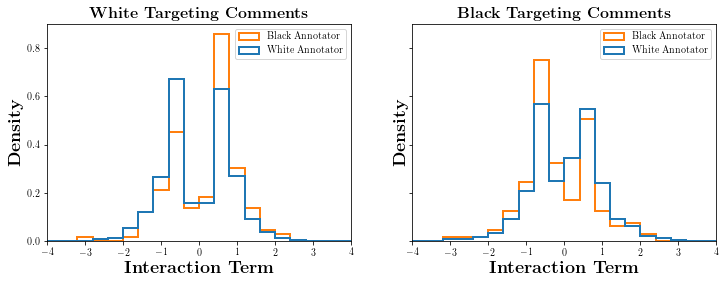

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 0) & (df['p_values'] < 0.5)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 0) & (df['p_values'] < 0.5)]['bias_corrected']],
    histtype='step',
    density=True,
    bins=np.linspace(-4, 4, 21),
    lw=2,
    label=['White Annotator', 'Black Annotator']
)

axes[1].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 1) & (df['p_values'] < 0.5)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 1) & (df['p_values'] < 0.5)]['bias_corrected']],
    histtype='step',
    density=True,
    lw=2,
    bins=np.linspace(-4, 4, 21),
    label=['White Annotator', 'Black Annotator']
)

axes[0].set_title(r'\textbf{White Targeting Comments}', fontsize=16)
axes[1].set_title(r'\textbf{Black Targeting Comments}', fontsize=16)

for ax in axes:
    ax.legend(loc='best')
    ax.set_xlim([-4, 4])
    ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=18)
    ax.set_ylabel(r'\textbf{Density}', fontsize=18)
    
#plt.savefig('interaction_terms_significant_annotators.png', dpi=300)

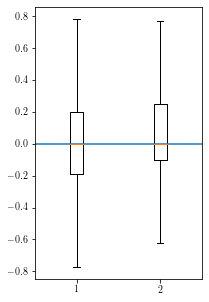

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5))

ax.boxplot(
    x=[df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected'],
       df[(df['annotator_race'] == 1) & (df['race'] == 0)]['bias_corrected']],
    showfliers=False
)
ax.axhline(0)

In [51]:
np.median(df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected'])

0.0

In [52]:
np.median(df[(df['annotator_race'] == 1) & (df['race'] == 0)]['bias_corrected'])

0.0

In [53]:
df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected']

0       0.09
1       0.41
2      -0.39
3      -0.00
4      -0.04
        ... 
4747    0.33
4748   -0.00
4749   -0.00
4750    0.46
4751   -0.00
Name: bias_corrected, Length: 4251, dtype: float64

In [71]:
df[(df['annotator_race'] == 1) & (df['race'] == 1)]['bias_corrected'].shape

(818,)

In [75]:
from scipy.stats import f_oneway, kruskal

f_oneway(
    df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected'].values,
    df[(df['annotator_race'] == 1) & (df['race'] == 0)]['bias_corrected'].values)

F_onewayResult(statistic=8.704003943516497, pvalue=0.003190624491126266)

In [41]:
f_oneway(
df[(df['annotator_race'] == 0) & (df['race'] == 1) & (df['p_values'] < 1)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 1) & (df['p_values'] < 1)]['bias_corrected'])

F_onewayResult(statistic=9.549641870183601, pvalue=0.0020079678537736046)

In [151]:
np.median(df[(df['annotator_race'] == 1) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected'])

0.855

In [80]:
target_black = df[df['race'] == 1].copy()
target_white = df[df['race'] == 0].copy()
common_annotators = target_black[target_black['labeler_id'].isin(target_white['labeler_id'])]['labeler_id'].values

In [90]:
diffs = (target_black[target_black['labeler_id'].isin(common_annotators)].sort_values('labeler_id')['bias_corrected'].reset_index(drop=True)
         - target_white[target_white['labeler_id'].isin(common_annotators)].sort_values('labeler_id')['bias_corrected'].reset_index(drop=True))

In [94]:
interaction_diffs = pd.DataFrame(data={'labeler_id': np.sort(common_annotators), 'interaction_diffs': diffs})

In [96]:
sev_diffs = pd.read_csv('severity_diffs.csv')

In [103]:
ruff = sev_diffs.merge(interaction_diffs, how='inner', on='labeler_id')

In [111]:
np.corrcoef(ruff['severity_diffs'], ruff['interaction_diffs'])

array([[1.        , 0.70916585],
       [0.70916585, 1.        ]])

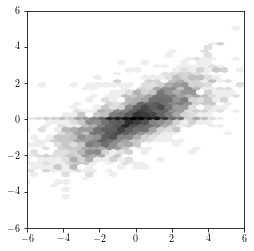

In [124]:
plt.hexbin(ruff['severity_diffs'], ruff['interaction_diffs'], cmap='Greys', bins='log', gridsize=40)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.gca().set_aspect('equal')

In [ ]:
# 5913
# 8133

In [30]:
annotator = 6028
df_comment = data[data['labeler_id'] == annotator][['predict_text', 'comment_id', race_to_col['black'], race_to_col['white']] + items].reset_index(drop=True)
avg_for_comments = pd.merge(
    left=df_comment,
    right=avg_scores,
    how='left',
    on='comment_id',
    suffixes=('_left', ''))[items]
df_comment[items] = df_comment[items] - avg_for_comments

In [31]:
df_comment

,predict_text,comment_id,target_race_1,target_race_6,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
0,Given time and circumstance the white supremacists would inbreed their genes. There is no such thing as racial purity. Its a long term path to extinction.,3683,NaN,1.0,0.333333,0.000000,0.666667,-0.333333,-0.333333,-0.333333,0.000000,0.000000,-0.333333,0.000000
1,He punched the white boy right out of him,2383,NaN,1.0,0.333333,0.000000,0.000000,0.333333,0.666667,0.000000,-0.333333,0.000000,0.000000,0.000000
2,"I'm all for equality. So fuck black people. And fuck hispanic people. And fuck muslims too. And asians. And indians. And jews for that matter, fuck them. And fuck this fat fuck in particular.",1191,1.0,1.0,-1.500000,-1.500000,-2.250000,-1.250000,-0.250000,-0.500000,0.000000,0.000000,-1.250000,-0.500000
3,"This is why we won, because Americans know that giving these people power for another day is unacceptable. We need to fight back against the Synagogue and their White/Mexican/Black Communist useful idiots they get to do their dirty work for them. I am armed and I am ready for these scum if they try to resist being sent back to Mexico/Guatemala all these illegal invaders that want to invade our nations and change it to suit their savage ways. Illegals must die.",20057,1.0,1.0,-0.948515,-0.928713,-0.770297,-1.384158,-0.924752,-0.835644,-0.954455,-0.914851,-0.871287,0.253465
4,"It's just really pointless and insulting to people who actually experience racism by implying our society is in need of a reminder that being a white person is okay. Because I doubt one genuine look at history would leave anyone wondering if ""being white"" in the U.S. will be perceived as a problem. The very concept of on a personal level being okay with the fact you were born with the skin color you were born with is of course not racist. But the statement just makes it seem like white people are at risk to become some sort of outcasts.",20052,NaN,1.0,-0.430647,-0.010568,0.206077,-0.130779,-0.120211,-0.060766,-0.003963,-0.003963,-0.051519,-0.025099


In [172]:
data[data['labeler_id'] == annotator][items]

,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
9558,4,3,2,0,0,1,0,0,2,0
20647,4,4,3,1,0,1,1,1,2,0
22461,4,4,3,2,1,1,1,0,3,0
